In [1]:
# import basic torch
import torch 
from torch import nn

# import base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import vision libraries
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms.v2 import ToTensor

/home/anikeet/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
train_data = datasets.FashionMNIST(
    root= 'data', # where to down the data
    train= True, # do we want train data?
    download=True, # to download it locally?
    transform = ToTensor(), # how do we want to transform the data
    target_transform=None, # how do we want to transform the labels
)

test_data = datasets.FashionMNIST(
    root= 'data', # where to down the data
    train= False, # do we want train data?
    download=True, # to download it locally?
    transform = ToTensor(), # how do we want to transform the data
    target_transform=None, # how do we want to transform the labels
)

/home/anikeet/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
class_names = train_data.classes

In [4]:
image, label = train_data[0]

image.shape, class_names[label]

(torch.Size([1, 28, 28]), 'Ankle boot')

Text(0.5, 1.0, 'Ankle boot')

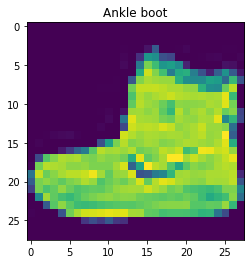

In [5]:
plt.imshow(image.squeeze())
plt.title(class_names[label])

(-0.5, 27.5, 27.5, -0.5)

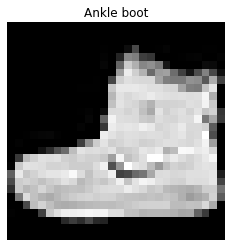

In [6]:
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])
plt.axis(False)

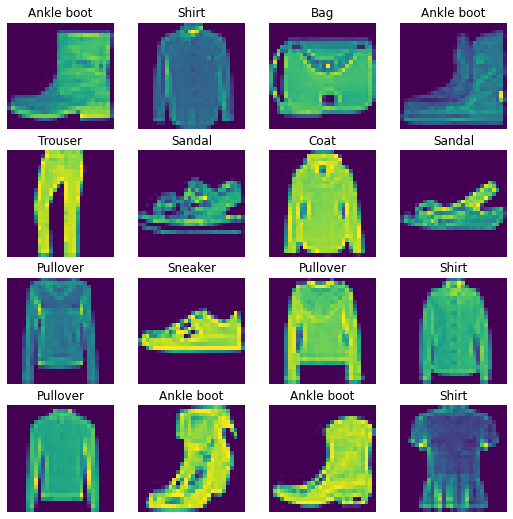

In [7]:
torch.manual_seed(42)
fig = plt.figure(figsize =(9, 9))
rows, cols = 4, 4
for i in range(1, (rows * cols) + 1):
    rand_index = torch.randint(0, len(train_data), size = [1]).item()
    img, label = train_data[rand_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze())
    plt.title(class_names[label])
    plt.axis(False)

In [8]:
## Loading data

BATCH_SIZES = 32

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset= train_data, 
                              batch_size= BATCH_SIZES,
                              shuffle=True,)

# dosent matter if data is shuffeled in test data, its easier for manually looking through when
# dataset is not shuffeled
test_dataloader = DataLoader(dataset= test_data, 
                              batch_size= BATCH_SIZES,
                              shuffle=False,)

print(train_dataloader, test_dataloader)
print("size ", len(train_dataloader), len(test_dataloader))

<torch.utils.data.dataloader.DataLoader object at 0x7f47c6a9f910> <torch.utils.data.dataloader.DataLoader object at 0x7f47c6a9e140>
size  1875 313


In [9]:
train_feature_batch, train_label_batch  = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

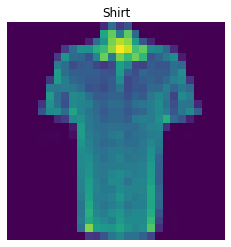

In [10]:
torch.manual_seed(42)

rand_idx = torch.randint(0, len(train_feature_batch), size= [1]).item()
img, label = train_feature_batch[rand_idx], train_label_batch[rand_idx]

plt.imshow(img.squeeze())
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [11]:
flatten_model = nn.Flatten()

x = train_feature_batch[0]

output = flatten_model(x)

print(x.shape, output.shape)

torch.Size([1, 28, 28]) torch.Size([1, 784])


In [12]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape:int,
                hidden_units:int,
                 output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features= hidden_units),
            nn.Linear(in_features=hidden_units, out_features= output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [13]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(28*28, 10, len(class_names))
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [14]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

from torchmetrics.classification import Accuracy

acc_fn = Accuracy(task = 'multiclass', num_classes = len(class_names))

In [15]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
    print("File already exits, skipping downloading")
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

File already exits, skipping downloading


In [16]:
# machine learning is very experimental
# lets check how fast out model run
from timeit import default_timer as timer
def print_train_time(start:float, end:float, device: torch.device):
    total_time =   end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [17]:
start = timer()

end = timer()

print_train_time(start, end, "cpu")

Train time on cpu: 0.000 seconds


1.4248000297811814e-05

In [18]:
torch.manual_seed(42)
from tqdm.auto import tqdm
train_time_on_cpu = timer()
epochs = 3
for epoch in range(epochs):
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0.forward(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()
        if batch % 400 == 0:
            print(f'Look at {batch * len(X)} / {len(train_dataloader.dataset)} samples')

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_0.eval()

    with torch.inference_mode():
        for batch_test , (X_test, y_test) in enumerate(test_dataloader):
            y_test_pred = model_0.forward(X_test)
            loss_test = loss_fn(y_test_pred, y_test)
            test_loss += loss_test

            test_acc = acc_fn(y_test, y_test_pred.argmax(dim = 1))

        test_loss /= len(test_dataloader)

    print(f'Train Loss {train_loss:.4f} | Test Loss {test_loss:.4f} | Test acc {test_acc:.4f}')

train_time_on_cpu_end = timer()

Look at 0 / 60000 samples
Look at 12800 / 60000 samples
Look at 25600 / 60000 samples
Look at 38400 / 60000 samples
Look at 51200 / 60000 samples
Train Loss 0.5904 | Test Loss 0.5095 | Test acc 0.8750
Look at 0 / 60000 samples
Look at 12800 / 60000 samples
Look at 25600 / 60000 samples
Look at 38400 / 60000 samples
Look at 51200 / 60000 samples
Train Loss 0.4763 | Test Loss 0.4799 | Test acc 0.9375
Look at 0 / 60000 samples
Look at 12800 / 60000 samples
Look at 25600 / 60000 samples
Look at 38400 / 60000 samples
Look at 51200 / 60000 samples
Train Loss 0.4550 | Test Loss 0.4766 | Test acc 0.9375


In [19]:
total_train_time_with_model_0 = print_train_time(train_time_on_cpu, train_time_on_cpu_end, "cpu")

Train time on cpu: 31.789 seconds


In [21]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn): 
    loss, acc = 0, 0
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
    
            # accumulate loss per batchabs
            loss += loss_fn(y_pred, y)
            acc += acc_fn(y, y_pred.argmax(dim = 1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name" : model.__class__.__name__,
            "model_loss" : loss,
            "model_acc"  : acc}

model_0_res = eval_model(model_0, test_dataloader, loss_fn, acc_fn)

In [22]:
model_0_res

{'model_name': 'FashionMNISTModelV0',
 'model_loss': tensor(0.4766),
 'model_acc': tensor(0.8343)}

In [23]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"